Preprocessing images into PATCH_SIZE patches with OVERLAP.
Saving into npz file containing train,val, test images.

Last updated: 07.06

Change: patch size 256, only taking first 11 depths to standardize input.




In [ ]:
# !pip install tifffile
# !pip install sklearn
# !pip install scikit-image

In [ ]:
# Constant values
IMG_SIZE = 512
OVERLAP = 0
PATCH_SIZE = 512
TYPES = ['NADH'] # up to 3 types: NADH, FAD, SDG
MAIN_PATH = r"/content/drive/MyDrive/Research and Grad/Diamond Program/objective_transfer"
NPZ_VER = "_3depths_3D" # version of data split

In [ ]:
# importing dependencies
import IPython.display as ipd
import numpy as np
import sklearn
import sklearn.model_selection
import skimage
import math
import numpy as np
from sklearn import preprocessing
import psutil
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import time

In [ ]:
# Open drive dynamically; prefer drives that have 'drive' in their name.
MAIN_DIR= r"/content/drive/MyDrive/Research and Grad/Diamond Program/objective_transfer/deep_learning"
from google.colab import drive
drive.mount('/content/drive')
os.chdir(MAIN_DIR+'/CAREstd/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def SoundNotification():
    global sound
    sr = 22050 # sample rate
    T = 0.5    # seconds
    t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
    x = 0.5*np.sin(2*np.pi*440*t)              # pure sine wave at 440 Hz
    sound = ipd.Audio(x, rate=sr, autoplay=True) # load a NumPy array

    return sound

def WhereIWantToUseTheSound():
    sound = SoundNotification()
    return sound

In [ ]:
from functools import wraps
import time


def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def create_patches(img, patch_shape, slide):
  # returns stack of patches and number of patches
  patch_img = skimage.util.view_as_windows(img, (patch_shape,patch_shape), step=patch_shape-slide)
  # # stacking patches
  # patch = np.zeros((patch_img.shape[0]*patch_img.shape[1],patch_shape,patch_shape))
  # # creating 3D array by stacking patches by rows
  # for row in range(patch_img.shape[0]):
  #     start = row*patch_img.shape[1]
  #     end = row*patch_img.shape[1]+patch_img.shape[1]
  #     patch[row*patch_img.shape[1]:row*patch_img.shape[1]+patch_img.shape[1],:,:] = patch_img[row, :, :,:]
  patch = patch_img.reshape(patch_img.shape[0]*patch_img.shape[1],patch_shape,patch_shape) # more time efficient
  return patch

def merge_patches(img, patch_shape, slide):
  #  merging patches
  row_len = int(math.sqrt(img.shape[0]))
  patches = np.zeros((row_len,row_len,patch_shape,patch_shape))
  print(patches.shape)
  for r in range(row_len):
      patches[r,:,:,:] = img[r*row_len:r*row_len+row_len,:,:]
  plt.figure(5)
  plt.imshow(patches[1,1,:,:])
  return revert_img(patches,patch_shape, slide)

def revert_img(img, patch_shape, slide):
  # reverts original image and removes overlaps by splitting overlap over 2 images
  step = int(patch_shape-slide)
  reconstructed_arr = np.zeros((1024,1024))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      start_x = int(slide/2)
      start_y = int(slide/2)
      end_x = 0
      end_y = 0
      if x == 0:
        start_x = 0
        end_x = int(slide/2)
      if y == 0:
        start_y = 0
        end_y = int(slide/2)
      if x == img.shape[0]-1: end_x = int(slide/2)
      if y == img.shape[1]-1: end_y = int(slide/2)
      x_pos, y_pos = x * step + start_x, y * step + start_y
      print(x, y, )
      reconstructed_arr[x_pos : x_pos + step + end_x, y_pos : y_pos + step + end_y] = img[x, y, start_x:start_x+step+end_x, start_y:start_y+step+end_y]
  return reconstructed_arr

def normalize(img):
  # Normalizing images between 0 and 1
  # img = img - img.min()
  # img = np.divide(img, img.max())
  # Normalizing images between 0 and 1 and preserving distribution
  img_norm = (img - np.amin(img))/( np.amax(img)- np.amin(img))
  return img_norm

def normalize_percentile(img, pmin=1, pmax=99.9, clip = False):
  eps=1e-20 # avoid zero division
  mi = np.percentile(img,pmin,axis=None,keepdims=True)
  # mi = np.amin(img)
  # print("mi",mi)
  ma = np.percentile(img,pmax,axis=None,keepdims=True)
  if clip == True: return np.clip((img - mi) / ( ma - mi + eps ), 0, 1)
  return (img - mi) / ( ma - mi + eps )

def concatenate(A,B):
  return np.concatenate((A,B)) if len(A)>0 else B

In [ ]:
# PREPROCESSING
# normalizing, splitting into patches, and then returning data, label arrays
def preprocess(ddict, patch_size, patch_overlap, types=['NADH'], process="up"):
  len_to_allocate = 0
  # getting number of input images
  for key in types:
    len_to_allocate = np.array(ddict['25X'][key]).shape[0]
  len_to_allocate = int(len_to_allocate*((patch_overlap-IMG_SIZE) / (patch_overlap-patch_size))**2)
  data = np.empty((len_to_allocate,patch_size,patch_size))
  labels = np.empty((len_to_allocate,patch_size,patch_size))
  count = 0
  for key in types:
    num_depths = np.asarray(ddict['25X'][key]).shape[0] # number of images/depths
    # for every 2D image/every depth
    for i in range(num_depths):
        # print("i: ",i)
        # Generating image patches with overlaps with chosen patch sizes and normalize
        # if not patchifying, img size == patch size
        if patch_size == IMG_SIZE:
          A = normalize_percentile(ddict['25X'][key][i, :, :])
          B = normalize_percentile(ddict['40X'][key][i, :, :])
        else:
          A = create_patches(normalize_percentile(ddict['25X'][key][i, :, :]), patch_size, patch_overlap)
          B = create_patches(normalize_percentile(ddict['40X'][key][i, :, :]), patch_size, patch_overlap)
        # appending, depending whether we are upscaling or downscaling
        if process=="down":
          C = A
          A = B
          B = C
        data[count:count+len(A),:,:] = A[:,:,:]
        del A # save memory
        labels[count:count+len(B),:,:] = B[:,:,:]
        count = count + len(B)
  return [data, labels]

def preprocess_stack(ddict,stack_name, patch_size, patch_overlap, types=['NADH'], process="up"):
  len_to_allocate = 0
  # getting number of input images
  for key in types:
    len_to_allocate += np.array(ddict['25X'][key][stack_name]).shape[2]
  len_to_allocate = int(len_to_allocate*((patch_overlap-IMG_SIZE) / (patch_overlap-patch_size))**2)
  data = np.empty((len_to_allocate,patch_size,patch_size))
  labels = np.empty((len_to_allocate,patch_size,patch_size))
  count = 0
  print("shape of data", np.shape(data))
  for key in types:
    # for every 2D image/every depth
    for i in range(np.array(ddict['25X'][key][stack_name]).shape[2]-1):
        # print("i: ",i)
        # Generating image patches with overlaps with chosen patch sizes and normalize
        A = create_patches(normalize_percentile(ddict['25X'][key][stack_name][:, :, i], 1, 99.9, clip=True), patch_size, patch_overlap)
        B = create_patches(normalize_percentile(ddict['40X'][key][stack_name][:, :, i], 1, 99.9, clip=True), patch_size, patch_overlap)
        # appending, depending whether we are upscaling or downscaling
        if process=="down":
          C = A
          A = B
          B = C
        data[count:count+len(A),:,:] = A[:,:,:]
        del A # save memory
        labels[count:count+len(B),:,:] = B[:,:,:]
        count = count + len(B)
  return [data, labels]

def preprocess3D(ddict,stack_name, patch_size, patch_overlap, types=['NADH'], process="up"):
   # generating 4D arrays of patches over depths with the shape [patches, patch size, patch size, depths]
    depths = NUM_OF_DEPTHS
    len_to_allocate = int(((patch_overlap-IMG_SIZE) / (patch_overlap-patch_size))**2)
    data = np.empty((len_to_allocate,patch_size,patch_size,depths-1))
    labels = np.empty((len_to_allocate,patch_size,patch_size,depths-1))
    for key in types:
      # for every 2D image/every depth
      for i in range(depths-1):
          # print("min(depths)-1: ",min(depths)-1, " shape: ", np.shape(ddict['25X'][key][stack_name][:, :, i]))
          # Generating image patches with overlaps with chosen patch sizes and normalize
          A = create_patches(normalize_percentile(ddict['25X'][key][stack_name][:, :, i]), patch_size, patch_overlap)
          B = create_patches(normalize_percentile(ddict['40X'][key][stack_name][:, :, i]), patch_size, patch_overlap)
          # appending, depending whether we are upscaling or downscaling
          if process=="down":
            C = A
            A = B
            B = C
          data[:,:,:,i] = A[:,:,:]
          del A # save memory
          labels[:,:,:,i] = B[:,:,:]
    return [data, labels]

def preprocess3D_fullsize_3_depths(ddict,stack_name, types='NADH', process="up"):
    # loading and normalizing stacks of train and label data, no 2D patchifying
    # return array of 3D stacks of 3 consecutive depths
    shape = np.shape(ddict['25X'][types][stack_name])
    print("Stack shape: ", shape,stack_name)
    depths = shape[-1]
    data = []
    labels = []
    # we will ignore first depth, start at 2nd depth and create 3D stack of previous,current, and next depth
    for i in range(1,depths-1):
      # creating 3depth stack
      A = ddict['25X'][types][stack_name][:, :, i-1:i+2]
      B = ddict['40X'][types][stack_name][:, :, i-1:i+2]
      # normalizing each depth 0 to 1
      for j in range(3):
        A[:,:,j] = normalize_percentile(A[:,:,j])
        B[:,:,j] = normalize_percentile(B[:,:,j])
      # appending, depending whether we are upscaling or downscaling
      if process=="down":
        C = A
        A = B
        B = C
      data = [A] if len(data) == 0 else np.concatenate((data,[A]))
      labels = [B] if len(labels) == 0 else np.concatenate((labels,[B]))
    print("SHAPE DATA: ", np.shape(data),stack_name)
    return [data, labels]

In [ ]:
main_path = MAIN_PATH
os.chdir(main_path+'/shifted_files')
data_dict = {'40X':{'NADH':{}, 'FAD':{}, 'SHG':{}}, '25X':{'NADH':{}, 'FAD':{}, 'SHG':{}}}
files = os.listdir()
results_folders = []
key_names = [] # to contain file names (ROIs) without '.mat'

# constructing paths to paired_results folders
# for file in files:
#     new_path = os.path.join(main_path, file)
#     if os.path.isdir(new_path) and 'results' in file:
#         paired_path = os.path.join(new_path, 'paired_results')
#         results_folders.append(paired_path)
# Populating dictionary
NADH = 0 # counting number of images
FAD = 0
# for result_folder in results_folders:
roi_mats = [] # to contain full file names
# os.chdir(result_folder)
experiment_files = os.listdir()
print(experiment_files)
# appending .mat files with w40XShift to roi_mats
for experiment_file in experiment_files:
    if experiment_file.endswith('.mat') and '512_shifted' in experiment_file:
        roi_mats.append(experiment_file)

mean40x = []
mean25x = []
count = 0
for roi in roi_mats:
    roi_name = roi[0:-4]
    print(roi_name)
    key_names.append(roi_name)
    mat_data = sio.loadmat(roi)
    count = count + np.shape(mat_data['nadh_512_shifted'][:, :, :, 1])[2]
    data_dict['40X']['NADH'][roi_name] = mat_data['nadh_512_shifted'][:, :, :, 1]
    data_dict['25X']['NADH'][roi_name] = mat_data['nadh_512_shifted'][:, :, :, 0]
del mat_data
print("count",count)

WhereIWantToUseTheSound()
print(NADH)
print(FAD)

['20210420_ROI2_512_shifted.mat', '20210420_ROI3_512_shifted.mat', '20210421_ROI4_512_shifted.mat', '20210421_ROI5_512_shifted.mat', '20210426_ROI1_512_shifted.mat', '20210426_ROI2_512_shifted.mat', '20210426_ROI3_512_shifted.mat', '20210426_ROI4_512_shifted.mat', '20210505_ROI1_512_shifted.mat', '20210505_ROI2_512_shifted.mat', '20210505_ROI3_512_shifted.mat', '20210505_ROI4_512_shifted.mat', '20210526_ROI3_512_shifted.mat', '20210615_ROI1_512_shifted.mat', '20210622_ROI4_512_shifted.mat']
20210420_ROI2_512_shifted
20210420_ROI3_512_shifted
20210421_ROI4_512_shifted
20210421_ROI5_512_shifted
20210426_ROI1_512_shifted
20210426_ROI2_512_shifted
20210426_ROI3_512_shifted
20210426_ROI4_512_shifted
20210505_ROI1_512_shifted
20210505_ROI2_512_shifted
20210505_ROI3_512_shifted
20210505_ROI4_512_shifted
20210526_ROI3_512_shifted
20210615_ROI1_512_shifted
20210622_ROI4_512_shifted
count 362
0
0


In [ ]:
# we are splitting train test val based on stacks, we have a total of 15 stacks
# we are generating 3D patches with each patch is 3D over set of depths of interest
training_indices = [0, 2, 4, 5, 6, 8, 9,10,11,12,7,13,14]
training_keys = [key_names[i] for i in training_indices]
val_indices = [1, 3, 6]
val_keys = [key_names[i] for i in val_indices]
# test_indices = [12, 13]
# test_keys = [key_names[i] for i in test_indices]

training_data = []
training_data_labels = []
# test_data = []
# test_data_labels = []
val_data = []
val_data_labels =[]
# max_depth = 10 # only taking total of 11 depths for consistency


for key in key_names:
    [data, label] = preprocess3D_fullsize_3_depths(data_dict, key, types='NADH', process="up")
    if key in training_keys:
        training_data = concatenate(training_data,data)
        training_data_labels = concatenate(training_data_labels,label)
    elif key in val_keys:
        val_data = concatenate(val_data,data)
        val_data_labels = concatenate(val_data_labels,label)

Stack shape:  (512, 512, 27) 20210420_ROI2_512_shifted
SHAPE DATA:  (25, 512, 512, 3) 20210420_ROI2_512_shifted
Stack shape:  (512, 512, 22) 20210420_ROI3_512_shifted
SHAPE DATA:  (20, 512, 512, 3) 20210420_ROI3_512_shifted
Stack shape:  (512, 512, 37) 20210421_ROI4_512_shifted
SHAPE DATA:  (35, 512, 512, 3) 20210421_ROI4_512_shifted
Stack shape:  (512, 512, 24) 20210421_ROI5_512_shifted
SHAPE DATA:  (22, 512, 512, 3) 20210421_ROI5_512_shifted
Stack shape:  (512, 512, 27) 20210426_ROI1_512_shifted
SHAPE DATA:  (25, 512, 512, 3) 20210426_ROI1_512_shifted
Stack shape:  (512, 512, 11) 20210426_ROI2_512_shifted
SHAPE DATA:  (9, 512, 512, 3) 20210426_ROI2_512_shifted
Stack shape:  (512, 512, 14) 20210426_ROI3_512_shifted
SHAPE DATA:  (12, 512, 512, 3) 20210426_ROI3_512_shifted
Stack shape:  (512, 512, 13) 20210426_ROI4_512_shifted
SHAPE DATA:  (11, 512, 512, 3) 20210426_ROI4_512_shifted
Stack shape:  (512, 512, 23) 20210505_ROI1_512_shifted
SHAPE DATA:  (21, 512, 512, 3) 20210505_ROI1_512_s

In [ ]:
print(np.shape(training_data),np.shape(training_data_labels),np.shape(val_data),np.shape(val_data_labels))
# np.set_printoptions(threshold=np.inf)
# mean40x = np.amax(training_data,axis=(1,2))
# plt.figure(figsize=(10,10))
# plt.hist(mean40x,bins=np.unique(mean40x))
# value, count = np.unique(mean40x, return_counts=True)
# print(value)
# print(count)

# mean25x = np.amax(training_data_labels,axis=(1,2))
# plt.figure(figsize=(10,10))
# plt.hist(mean25x,bins=np.unique(mean25x))
# print(np.shape(mean25x))
# value, count = np.unique(mean25x, return_counts=True)
# print(value)
# print(count)

(290, 512, 512, 3) (290, 512, 512, 3) (42, 512, 512, 3) (42, 512, 512, 3)


In [ ]:
# # split 1024x1024px images into test and train/val and save all images with mixed depths into corresponding list in dict
# test_dict = {'40X':{'NADH':[], 'FAD':[], 'SHG':[]}, '25X':{'NADH':[], 'FAD':[], 'SHG':[]}}
# for key in TYPES:
#   ids = range(len(data_dict['25X'][key]))
#   X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(ids, ids, test_size=TEST_SIZE, random_state=1,shuffle=True)
#   test_dict['25X'][key] = concatenate(test_dict['25X'][key],data_dict['25X'][key][X_test, :,:])
#   test_dict['40X'][key] = concatenate(test_dict['40X'][key],data_dict['40X'][key][X_test, :,:])
#   data_dict['25X'][key] = np.delete(data_dict['25X'][key], X_test,axis=0)
#   data_dict['40X'][key] = np.delete(data_dict['40X'][key], X_test,axis=0)

In [ ]:
# avoid having the same stack appear in both training and testing

In [ ]:
# # preprocessing and patching data
# # plt.figure(figsize = (10,10))
# # plt.imshow(data_dict['40X']['NADH'][25,:,:])
# [data, labels] = preprocess(data_dict, PATCH_SIZE, OVERLAP, types=['NADH'], process="up")
# # del data_dict

In [ ]:
# # preprocessing and patching test data
# [test_data, test_data_labels] = preprocess(test_dict, PATCH_SIZE, OVERLAP, types=['NADH'], process="up")
# # del test_dict

In [ ]:
# # splitting train and validation
# # bloddy hell the train_test_split blows up memory, instead splitting ids
# ids = range(data.shape[0])
# X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(ids, ids, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=1,shuffle=True)

# training_data = data[X_train,:,:]
# data[X_train,:,:] = 0
# val_data = data[X_val,:,:]
# data[X_val,:,:] = 0
# del data
# training_data_labels = labels[y_train,:,:]
# labels[y_train,:,:] = 0
# val_data_labels = labels[y_val,:,:]
# labels[y_val,:,:] = 0
# del labels
# print("Train size, test size, and validation size: ",training_data.shape,", ",val_data.shape)
# WhereIWantToUseTheSound()

In [ ]:
print("training", np.shape(training_data))
print("val",np.shape(val_data))
print(np.unique(training_data[0,...]))

training (290, 512, 512, 3)
val (42, 512, 512, 3)
[0.         0.03293577 0.03369485 ... 1.32610298 1.33410551 1.33887734]


(array([7.9280e+03, 0.0000e+00, 1.5250e+03, 0.0000e+00, 0.0000e+00,
        4.5720e+03, 0.0000e+00, 2.1000e+01, 9.1530e+03, 0.0000e+00,
        1.2900e+02, 1.4795e+04, 0.0000e+00, 3.5500e+02, 1.9815e+04,
        8.1100e+02, 2.8000e+01, 2.3621e+04, 1.4050e+03, 4.4000e+01,
        2.4564e+04, 2.2000e+03, 2.3850e+04, 4.8000e+01, 2.7760e+03,
        2.1423e+04, 1.1100e+02, 3.4520e+03, 1.8019e+04, 7.0000e+00,
        3.6740e+03, 1.4562e+04, 8.0000e+00, 3.7240e+03, 1.1408e+04,
        3.5470e+03, 3.7000e+01, 8.5730e+03, 3.1860e+03, 3.5000e+01,
        6.2260e+03, 2.7570e+03, 3.8680e+03, 5.6700e+02, 2.2640e+03,
        2.5840e+03, 5.4900e+02, 1.8660e+03, 1.5960e+03, 5.2300e+02,
        1.3940e+03, 1.5130e+03, 5.0000e+00, 1.0990e+03, 1.0340e+03,
        7.1600e+02, 1.0600e+02, 7.2900e+02, 4.6400e+02, 8.1000e+01,
        4.8000e+02, 2.9400e+02, 2.0100e+02, 2.6000e+02, 2.8600e+02,
        7.0000e+01, 1.4300e+02, 1.6700e+02, 3.9000e+01, 1.4000e+02,
        1.2000e+02, 9.0000e+01, 2.2000e+01, 9.30

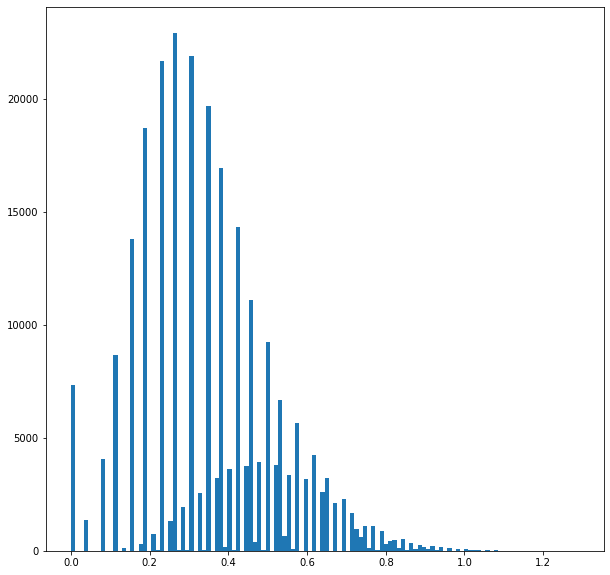

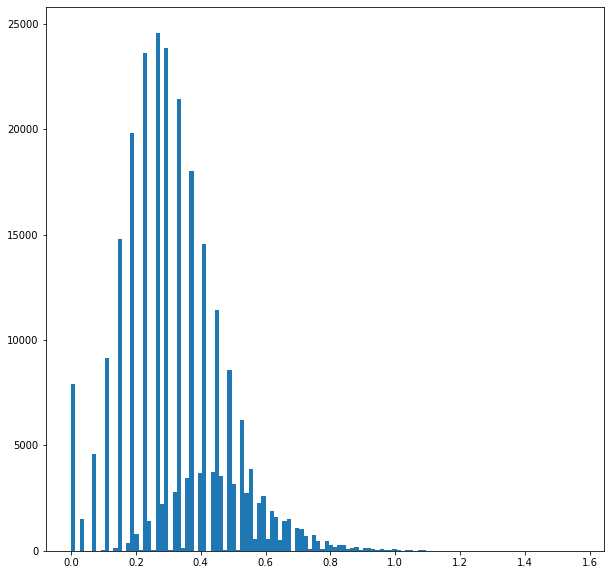

In [ ]:
plt.figure(figsize=(10,10))
plt.hist(training_data[0,...,0].flatten(), bins=120)
plt.figure(figsize=(10,10))
plt.hist(training_data_labels[0,...,0].flatten(), bins=120)

In [ ]:
print(np.count_nonzero((training_data_labels)<0))


773904


In [ ]:
print(np.shape(training_data))
np.savez(MAIN_PATH+'/deep_learning/npz/Cervix_all_data'+str(NPZ_VER)+'.npz',t= np.float32(training_data), v=np.float32(val_data))
np.savez(MAIN_PATH+'/deep_learning/npz/Cervix_all_data_labels'+ str(NPZ_VER)+'.npz',t= np.float32(training_data_labels), v=np.float32(val_data_labels))

(290, 512, 512, 3)
